# Stage 1 Supplementary Analysis: TOPUP + EDDY 

In [6]:
# Imports + shared options (paths, plotting theme, sampling config)
from __future__ import annotations

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import bambi as bmb
import arviz as az

# Reproducible file layout (simple to upload to OSF/GitHub)
NOTEBOOK_DIR = Path.cwd()
DATA_DIR = NOTEBOOK_DIR / "data"
OUT_DIR = NOTEBOOK_DIR / "outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

TOPUP_CSV = DATA_DIR / "topup_metrics.csv"
EDDY_CSV = DATA_DIR / "eddy_metrics.csv"

# Plot styling
sns.set_theme(style="whitegrid")

# Shared sampling configuration (set once, used for all models)
# Notes:
# - small-N topup datasets can hit max_treedepth; we set it explicitly
# - slightly higher target_accept tends to reduce treedepth warnings/divergences
FIT_KWARGS = dict(
    draws=2000,
    tune=1000,
    chains=4,
    cores=4,
    random_seed=42,
    nuts={"target_accept": 0.995, "max_treedepth": 15},
    idata_kwargs={"log_likelihood": True},
)

def _normalise_condition(df: pd.DataFrame, col: str = "condition") -> pd.DataFrame:
    """Map `original -> non-denoised` and enforce ordered categorical."""
    if col not in df.columns:
        raise ValueError(f"Missing required column: {col}")
    df[col] = df[col].replace({"original": "non-denoised"})
    df[col] = pd.Categorical(df[col], categories=["non-denoised", "denoised"], ordered=True)
    return df

def _coerce_numeric(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    for c in cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def _validate_columns(df: pd.DataFrame, required: list[str], name: str) -> None:
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(
            f"{name}: missing required columns: {missing}\n"
            f"{name}: available columns: {df.columns.tolist()}"
        )

def _save_manifest(paths: list[Path]) -> None:
    paths = [p for p in paths if p is not None]
    print("\nSaved outputs:")
    for p in paths:
        try:
            rel = p.relative_to(NOTEBOOK_DIR)
        except Exception:
            rel = p
        print(f"- {rel}")

print("=" * 70)
print("STAGE1_SUPP_ANALYSIS: SETUP")
print("=" * 70)
print(f"Working directory: {NOTEBOOK_DIR}")
print(f"Topup CSV:         {TOPUP_CSV}")
print(f"Eddy CSV:          {EDDY_CSV}")
print(f"Outputs directory: {OUT_DIR}")
print("=" * 70)

STAGE1_SUPP_ANALYSIS: SETUP
Working directory: /home/lpxfd2/Documents/Code/denoise_harmonisation/Registered_Report
Topup CSV:         /home/lpxfd2/Documents/Code/denoise_harmonisation/Registered_Report/data/topup_metrics.csv
Eddy CSV:          /home/lpxfd2/Documents/Code/denoise_harmonisation/Registered_Report/data/eddy_metrics.csv
Outputs directory: /home/lpxfd2/Documents/Code/denoise_harmonisation/Registered_Report/outputs


TOPUP loaded: (12, 9)
Unique scans: 6
Conditions: ['non-denoised', 'denoised']


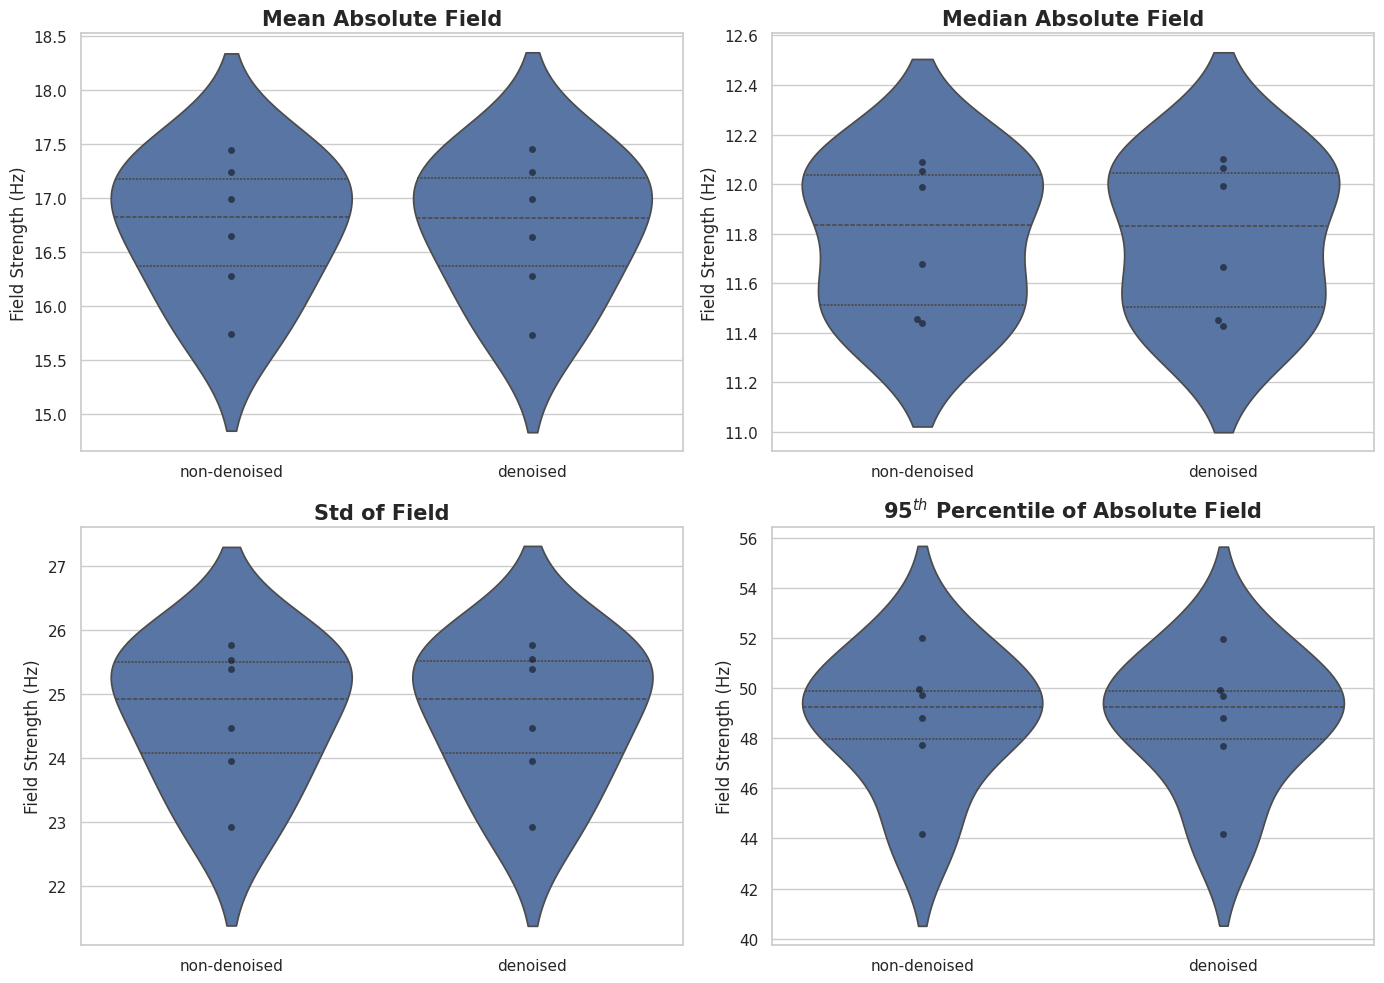


Saved outputs:
- outputs/topup_violin.png


In [7]:
# TOPUP — Violin + swarm plot
df_topup = pd.read_csv(TOPUP_CSV)

topup_metrics = ["mean_abs_field", "median_abs_field", "std_field", "p95_abs_field"]
topup_required = ["scan_id", "session", "condition"] + topup_metrics
_validate_columns(df_topup, topup_required, name="TOPUP")

df_topup = _coerce_numeric(df_topup, topup_metrics)
df_topup = df_topup.dropna(subset=topup_required).copy()
df_topup = _normalise_condition(df_topup)
df_topup["scan_id"] = df_topup["scan_id"].astype("category")

print("TOPUP loaded:", df_topup.shape)
print("Unique scans:", df_topup["scan_id"].nunique())
print("Conditions:", df_topup["condition"].cat.categories.tolist())

titles = [
    "Mean Absolute Field",
    "Median Absolute Field",
    "Std of Field",
    r"95$^{th}$ Percentile of Absolute Field",
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, metric, title in zip(axes, topup_metrics, titles):
    sns.violinplot(data=df_topup, x="condition", y=metric, inner="quartile", ax=ax)
    sns.swarmplot(data=df_topup, x="condition", y=metric, alpha=0.5, color="black", size=5, ax=ax)
    ax.set_title(title, fontsize=15, fontweight="bold")
    ax.set_xlabel("")
    ax.set_ylabel("Field Strength (Hz)")

plt.tight_layout()
topup_violin_path = OUT_DIR / "topup_violin.png"
fig.savefig(topup_violin_path, dpi=300, bbox_inches="tight")
plt.show()

_save_manifest([topup_violin_path])


TOPUP: Fitting model for mean_abs_field


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, condition, 1|scan_id_sigma, 1|scan_id_offset]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, condition, 1|scan_id_sigma, 1|scan_id_offset]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 630 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
condition[denoised],-0.002,0.004,-0.009,0.005,0.000,0.000,2584.0,1778.0,1.0
1|scan_id_sigma,0.852,0.369,0.381,1.577,0.012,0.023,848.0,1110.0,1.0


Max R-hat: 1.003
Divergences: 0


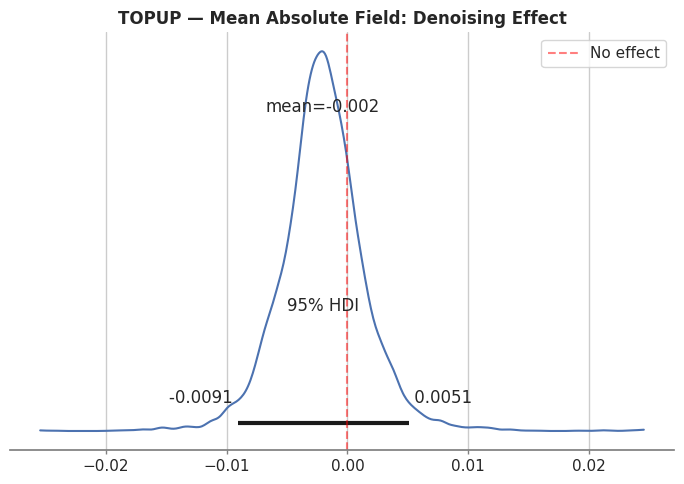


TOPUP: Fitting model for median_abs_field


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, condition, 1|scan_id_sigma, 1|scan_id_offset]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, condition, 1|scan_id_sigma, 1|scan_id_offset]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 225 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
condition[denoised],0.000,0.007,-0.013,0.014,0.000,0.000,2151.0,2066.0,1.0
1|scan_id_sigma,0.396,0.166,0.169,0.719,0.005,0.007,1059.0,1408.0,1.0


Max R-hat: 1.007
Divergences: 0


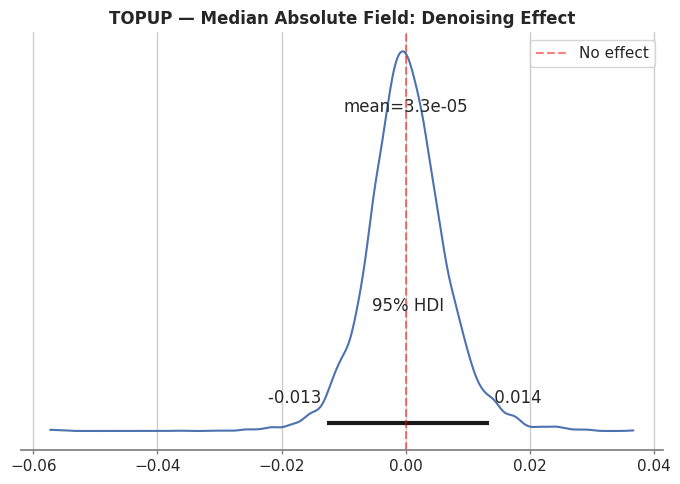


TOPUP: Fitting model for std_field


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, condition, 1|scan_id_sigma, 1|scan_id_offset]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, condition, 1|scan_id_sigma, 1|scan_id_offset]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 923 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
condition[denoised],0.005,0.005,-0.005,0.015,0.000,0.000,1501.0,1313.0,1.01
1|scan_id_sigma,1.450,0.619,0.599,2.583,0.019,0.022,1037.0,1790.0,1.01


Max R-hat: 1.005
Divergences: 0


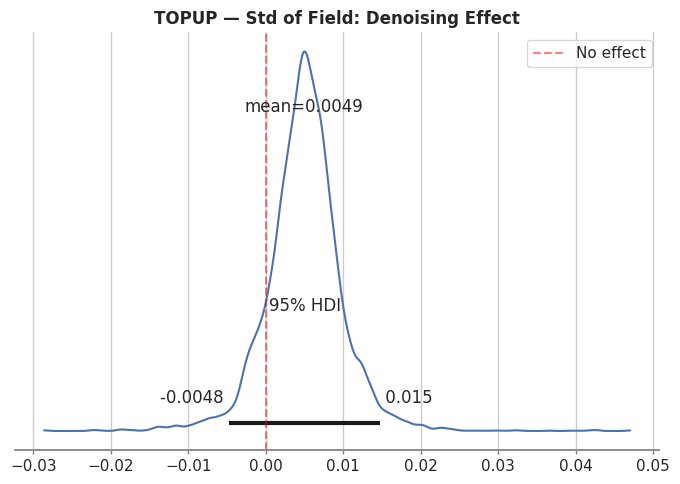


TOPUP: Fitting model for p95_abs_field


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, condition, 1|scan_id_sigma, 1|scan_id_offset]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, condition, 1|scan_id_sigma, 1|scan_id_offset]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1603 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
condition[denoised],-0.009,0.006,-0.021,0.001,0.000,0.000,2284.0,1899.0,1.0
1|scan_id_sigma,3.505,1.595,1.445,6.470,0.054,0.087,874.0,1244.0,1.0


Max R-hat: 1.005
Divergences: 0


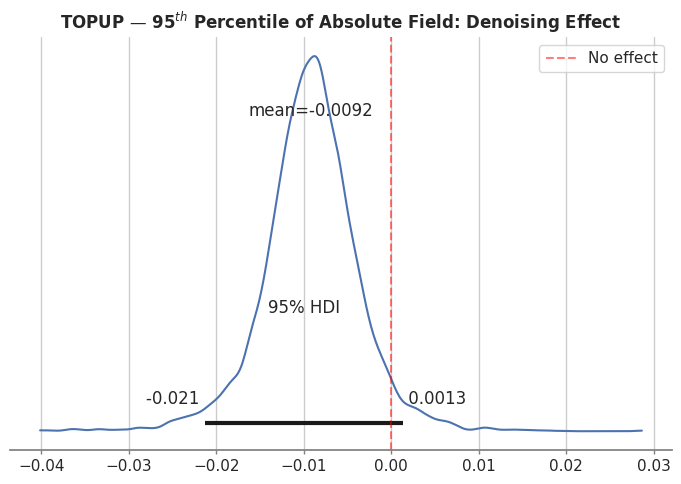


Saved outputs:
- outputs/topup_model_summary_mean_abs_field.csv
- outputs/topup_model_summary_median_abs_field.csv
- outputs/topup_model_summary_std_field.csv
- outputs/topup_model_summary_p95_abs_field.csv
- outputs/topup_posterior_mean_abs_field.png
- outputs/topup_posterior_median_abs_field.png
- outputs/topup_posterior_std_field.png
- outputs/topup_posterior_p95_abs_field.png


In [8]:
# TOPUP — Bayesian mixed-effects models + posterior plots
topup_saved = []
topup_summaries = []

for metric, title in zip(topup_metrics, titles):
    print(f"\n{'=' * 70}")
    print(f"TOPUP: Fitting model for {metric}")
    print(f"{'=' * 70}")

    model = bmb.Model(f"{metric} ~ condition + (1|scan_id)", data=df_topup)
    idata = model.fit(**FIT_KWARGS)

    # Summary CSV (condition effect + scan random-effect sd)
    cond_vars = [v for v in idata.posterior.data_vars if "condition" in v]
    summary = az.summary(
        idata,
        var_names=cond_vars + ["1|scan_id_sigma"],
        hdi_prob=0.95,
    )
    display(summary)

    summary_path = OUT_DIR / f"topup_model_summary_{metric}.csv"
    summary.to_csv(summary_path)
    topup_summaries.append(summary_path)

    # Diagnostics
    rhat_ds = az.rhat(idata)
    max_rhat = float(rhat_ds.to_array().max())
    try:
        n_div = int(idata.sample_stats["diverging"].values.sum())
    except Exception:
        n_div = None
    print(f"Max R-hat: {max_rhat:.3f}")
    print("Divergences:", n_div)

    # Posterior plot
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    az.plot_posterior(idata, var_names=cond_vars, hdi_prob=0.95, ax=ax)
    ax.axvline(0, color="red", linestyle="--", alpha=0.5, label="No effect")
    ax.set_title(f"TOPUP — {title}: Denoising Effect", fontweight="bold")
    ax.legend()
    plt.tight_layout()

    post_path = OUT_DIR / f"topup_posterior_{metric}.png"
    fig.savefig(post_path, dpi=300, bbox_inches="tight")
    plt.show()
    topup_saved.append(post_path)

_save_manifest(topup_summaries + topup_saved)

EDDY loaded: (1308, 15)
Unique scans: 6
Conditions: ['non-denoised', 'denoised']


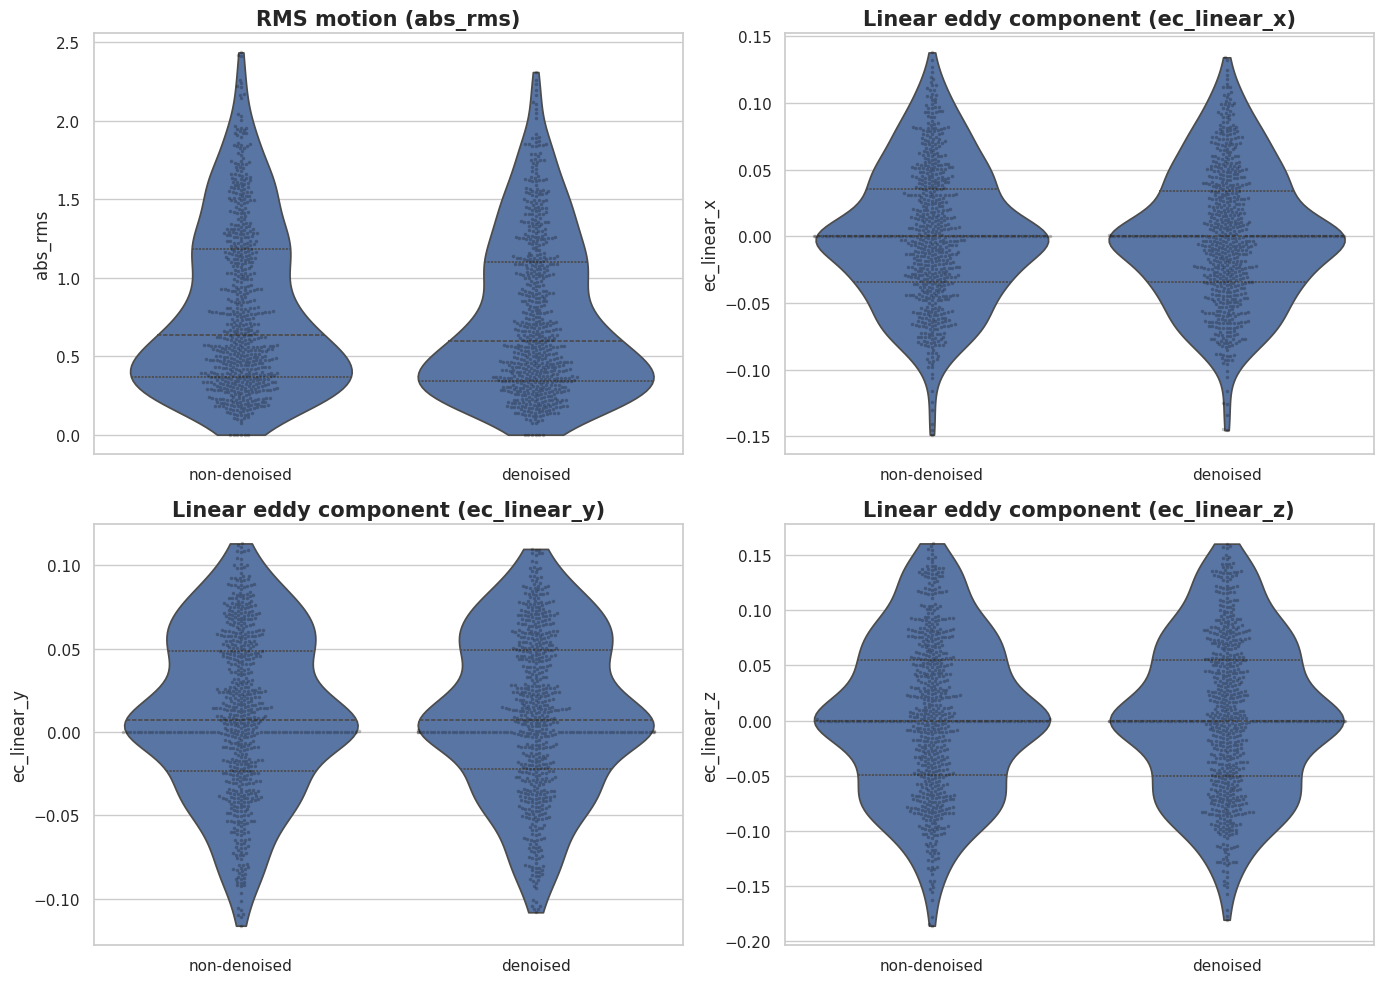


Saved outputs:
- outputs/eddy_violin.png


In [9]:
# EDDY — Violin + swarm plot
df_eddy = pd.read_csv(EDDY_CSV)

eddy_metrics = ["abs_rms", "ec_linear_x", "ec_linear_y", "ec_linear_z"]
eddy_required = ["scan_id", "session", "condition"] + eddy_metrics
_validate_columns(df_eddy, eddy_required, name="EDDY")

df_eddy = _coerce_numeric(df_eddy, eddy_metrics)
df_eddy = df_eddy.dropna(subset=eddy_required).copy()
df_eddy = _normalise_condition(df_eddy)
df_eddy["scan_id"] = df_eddy["scan_id"].astype("category")

print("EDDY loaded:", df_eddy.shape)
print("Unique scans:", df_eddy["scan_id"].nunique())
print("Conditions:", df_eddy["condition"].cat.categories.tolist())

eddy_titles = [
    "RMS motion (abs_rms)",
    "Linear eddy component (ec_linear_x)",
    "Linear eddy component (ec_linear_y)",
    "Linear eddy component (ec_linear_z)",
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, metric, title in zip(axes, eddy_metrics, eddy_titles):
    sns.violinplot(data=df_eddy, x="condition", y=metric, inner="quartile", cut=0, ax=ax)
    sns.swarmplot(data=df_eddy, x="condition", y=metric, alpha=0.25, color="black", size=2.5, ax=ax)
    ax.set_title(title, fontsize=15, fontweight="bold")
    ax.set_xlabel("")
    ax.set_ylabel(metric)

plt.tight_layout()
eddy_violin_path = OUT_DIR / "eddy_violin.png"
fig.savefig(eddy_violin_path, dpi=300, bbox_inches="tight")
plt.show()

_save_manifest([eddy_violin_path])


EDDY: Fitting model for abs_rms


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, condition, 1|scan_id_sigma, 1|scan_id_offset]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, condition, 1|scan_id_sigma, 1|scan_id_offset]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
condition[denoised],-0.053,0.029,-0.111,0.003,0.000,0.000,6304.0,4539.0,1.0
1|scan_id_sigma,0.059,0.040,0.000,0.131,0.001,0.001,1649.0,2285.0,1.0


Max R-hat: 1.004
Divergences: 0


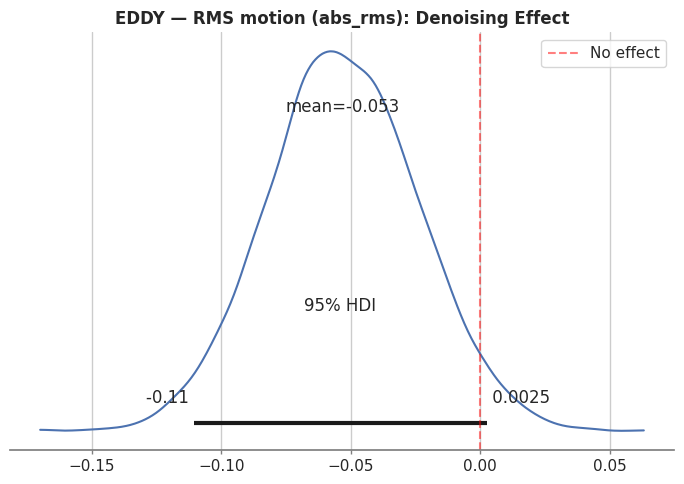


EDDY: Fitting model for ec_linear_x


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, condition, 1|scan_id_sigma, 1|scan_id_offset]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, condition, 1|scan_id_sigma, 1|scan_id_offset]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 35 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
condition[denoised],-0.001,0.003,-0.006,0.005,0.0,0.0,6784.0,5467.0,1.0
1|scan_id_sigma,0.004,0.004,0.000,0.010,0.0,0.0,1336.0,1698.0,1.0


Max R-hat: 1.004
Divergences: 0


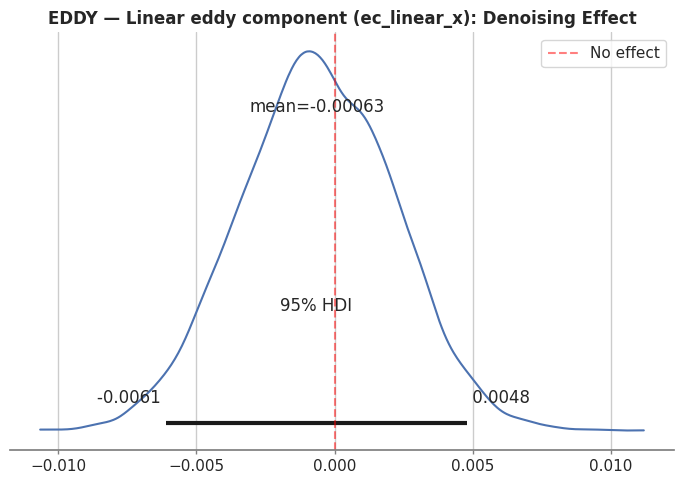


EDDY: Fitting model for ec_linear_y


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, condition, 1|scan_id_sigma, 1|scan_id_offset]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, condition, 1|scan_id_sigma, 1|scan_id_offset]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 30 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
condition[denoised],0.000,0.003,-0.005,0.006,0.0,0.0,8047.0,6259.0,1.0
1|scan_id_sigma,0.003,0.003,0.000,0.008,0.0,0.0,2345.0,3380.0,1.0


Max R-hat: 1.001
Divergences: 0


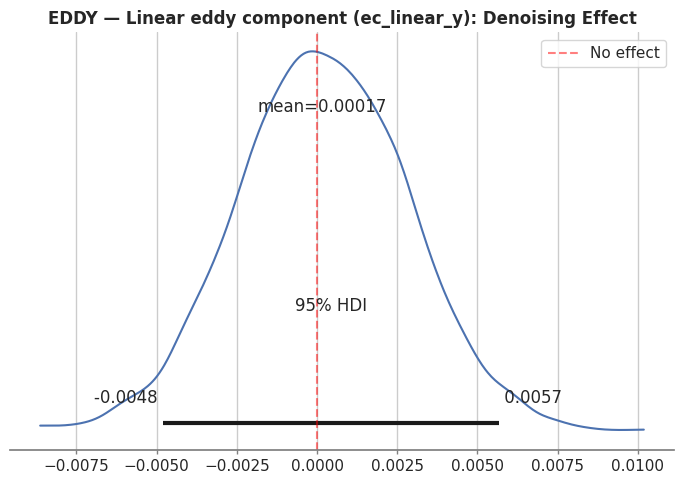


EDDY: Fitting model for ec_linear_z


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, condition, 1|scan_id_sigma, 1|scan_id_offset]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, condition, 1|scan_id_sigma, 1|scan_id_offset]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
condition[denoised],0.000,0.004,-0.007,0.008,0.0,0.0,6147.0,5624.0,1.00
1|scan_id_sigma,0.005,0.004,0.000,0.014,0.0,0.0,1874.0,2751.0,1.01


Max R-hat: 1.006
Divergences: 0


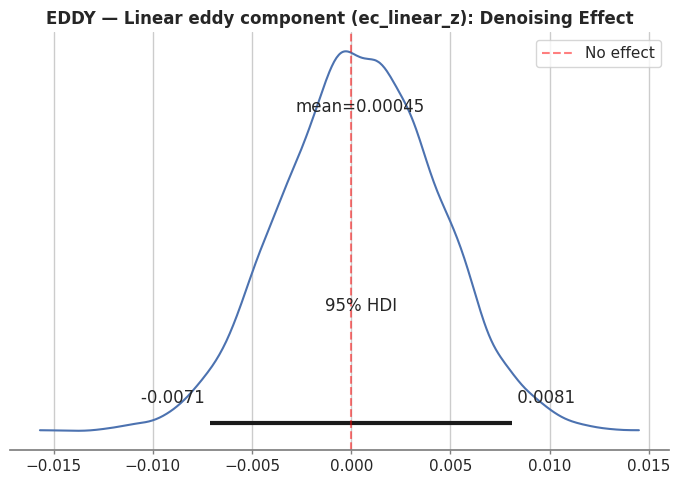


Saved outputs:
- outputs/eddy_model_summary_abs_rms.csv
- outputs/eddy_model_summary_ec_linear_x.csv
- outputs/eddy_model_summary_ec_linear_y.csv
- outputs/eddy_model_summary_ec_linear_z.csv
- outputs/eddy_posterior_abs_rms.png
- outputs/eddy_posterior_ec_linear_x.png
- outputs/eddy_posterior_ec_linear_y.png
- outputs/eddy_posterior_ec_linear_z.png


In [10]:
# EDDY — Bayesian mixed-effects models + posterior plots
eddy_saved = []
eddy_summaries = []

for metric, title in zip(eddy_metrics, eddy_titles):
    print(f"\n{'=' * 70}")
    print(f"EDDY: Fitting model for {metric}")
    print(f"{'=' * 70}")

    model = bmb.Model(f"{metric} ~ condition + (1|scan_id)", data=df_eddy)
    idata = model.fit(**FIT_KWARGS)

    cond_vars = [v for v in idata.posterior.data_vars if "condition" in v]
    summary = az.summary(
        idata,
        var_names=cond_vars + ["1|scan_id_sigma"],
        hdi_prob=0.95,
    )
    display(summary)

    summary_path = OUT_DIR / f"eddy_model_summary_{metric}.csv"
    summary.to_csv(summary_path)
    eddy_summaries.append(summary_path)

    rhat_ds = az.rhat(idata)
    max_rhat = float(rhat_ds.to_array().max())
    try:
        n_div = int(idata.sample_stats["diverging"].values.sum())
    except Exception:
        n_div = None
    print(f"Max R-hat: {max_rhat:.3f}")
    print("Divergences:", n_div)

    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    az.plot_posterior(idata, var_names=cond_vars, hdi_prob=0.95, ax=ax)
    ax.axvline(0, color="red", linestyle="--", alpha=0.5, label="No effect")
    ax.set_title(f"EDDY — {title}: Denoising Effect", fontweight="bold")
    ax.legend()
    plt.tight_layout()

    post_path = OUT_DIR / f"eddy_posterior_{metric}.png"
    fig.savefig(post_path, dpi=300, bbox_inches="tight")
    plt.show()
    eddy_saved.append(post_path)

_save_manifest(eddy_summaries + eddy_saved)